In [7]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import bisect

In [8]:
plt.style.use('ggplot')
sns.set_palette("viridis")
plt.rcParams.update({'font.size': 12})


In [9]:
def load_evaluation(path='results/evaluation.json'):
    with open(path, 'r') as f:
        evaluation = json.load(f)
    return evaluation 

def parse_evaluation(evaluation):
    parsed = {}
    for key_str, value in evaluation.items():
        try:
            key_obj = json.loads(key_str)
            if key_str == "null":
                parsed["total_tests"] = value
            elif isinstance(key_obj, list):
                parsed[tuple(key_obj)] = value
        except:
            parsed[key_str] = value
    return parsed

raw_evaluation = load_evaluation()
evaluation = parse_evaluation(raw_evaluation)

### 1. Overall Success Rate 

In [11]:
total_tests = evaluation["total_tests"]
total_success = evaluation[("symptoms", "*", 5.3, "success")]
overall_success_rate = total_success / total_tests

print(f"Overall Success Rate: {overall_success_rate:.2%} ({total_success}/{total_tests})")


Overall Success Rate: 60.12% (3066/5100)


### 2. Top n most frequent diseases and their success rates 

In [12]:
def extract_disease_data(evaluation):
    diseases = []
    
    for key, value in evaluation.items():
        if isinstance(key, tuple) and len(key) == 2 and key[0] == "symptoms" and key[1] != "*":
            disease_name = key[1]
            total_count = value
            
            # Get successful count
            success_key = ("symptoms", disease_name, 5.3, "success")
            success_count = evaluation.get(success_key, 0)
            
            success_rate = success_count / total_count if total_count > 0 else 0
            
            diseases.append({
                "disease": disease_name,
                "total_count": total_count,
                "success_count": success_count,
                "success_rate": success_rate
            })
    
    return pd.DataFrame(diseases)

df_diseases = extract_disease_data(evaluation)
df_diseases = df_diseases.sort_values("total_count", ascending=False)


In [25]:
df_diseases.head(7)

,disease,total_count,success_count,success_rate
14,Snurflaxitis,289,240,0.830450
15,Snurflesauce Overdosis,231,0,0.000000
19,Norglesnap Fever,220,219,0.995455
3,Snizzlejerk Fever,197,0,0.000000
28,Flibberflamia Frigibulitis,194,194,1.000000
11,Nerdledonsosis,181,175,0.966851
21,Flibberflamius Extremus,175,174,0.994286


<Figure size 1500x800 with 0 Axes>

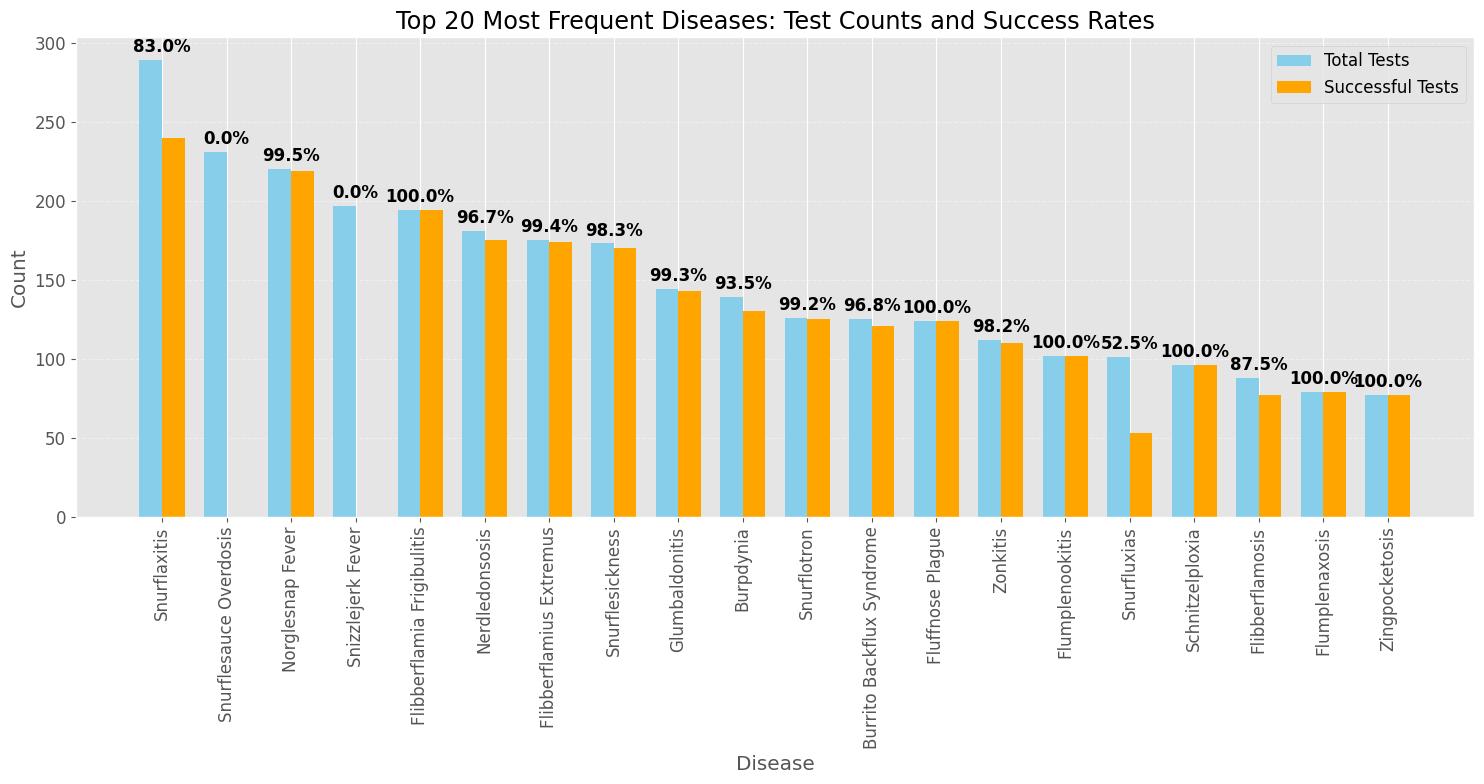

In [28]:
plt.figure(figsize=(15, 8))
top_diseases = df_diseases.head(20) # change this!! if you want to change n

x = np.arange(len(top_diseases))
width = 0.35

fig, ax = plt.subplots(figsize=(15, 8))
total_bars = ax.bar(x - width/2, top_diseases['total_count'], width, label='Total Tests', color='skyblue')
success_bars = ax.bar(x + width/2, top_diseases['success_count'], width, label='Successful Tests', color='orange')

# add suc rates
for i, disease in enumerate(top_diseases['disease']):
    success_rate = top_diseases.iloc[i]['success_rate']
    y_pos = max(top_diseases.iloc[i]['total_count'], top_diseases.iloc[i]['success_count']) + 5
    plt.text(i, y_pos, f"{success_rate:.1%}", ha='center', fontweight='bold')

ax.set_title("Top 20 Most Frequent Diseases: Test Counts and Success Rates")
ax.set_xlabel("Disease")
ax.set_ylabel("Count")
ax.set_xticks(x)
ax.set_xticklabels(top_diseases['disease'], rotation=90)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

### 3. Distribution of success rates

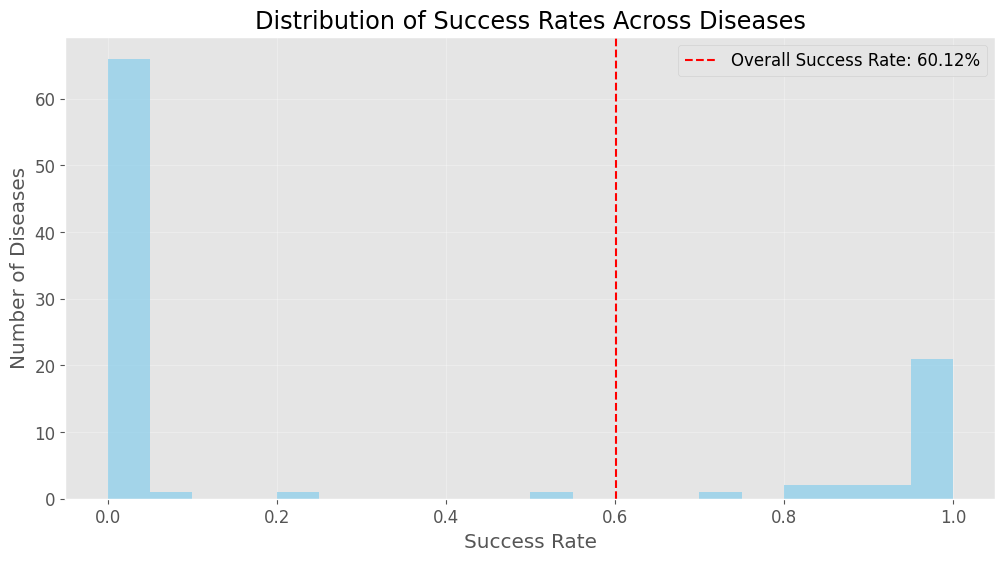

In [37]:
plt.figure(figsize=(12, 6))
plt.hist(df_diseases['success_rate'], bins=20, alpha=0.7, color='skyblue')
plt.axvline(x=overall_success_rate, color='red', linestyle='--', label=f'Overall Success Rate: {overall_success_rate:.2%}')
plt.title('Distribution of Success Rates Across Diseases')
plt.xlabel('Success Rate')
plt.ylabel('Number of Diseases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 4. Scatter plot of disease frequency vs success rate

/var/folders/yn/rr0rpgh91mvgqtf5jnmfz3fw0000gn/T/ipykernel_47324/2342956120.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


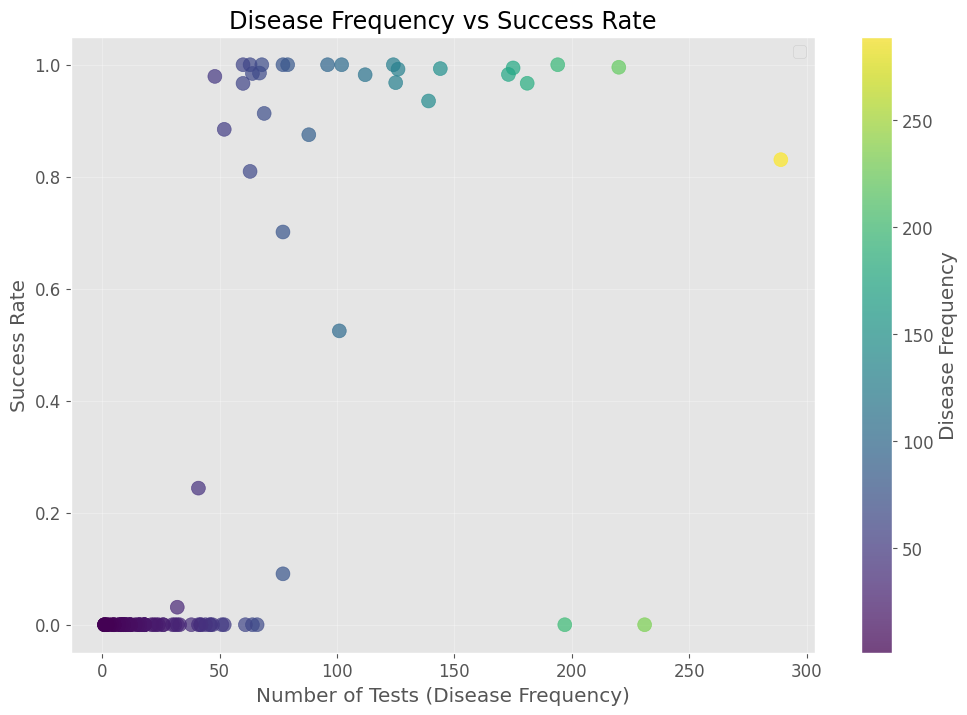

In [20]:
plt.figure(figsize=(12, 8))
plt.scatter(df_diseases['total_count'], df_diseases['success_rate'], 
           alpha=0.7, c=df_diseases['total_count'], cmap='viridis', s=100)

plt.title('Disease Frequency vs Success Rate')
plt.xlabel('Number of Tests (Disease Frequency)')
plt.ylabel('Success Rate')
plt.colorbar(label='Disease Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### 5. Zero success (success_rate = 0.0) diseases

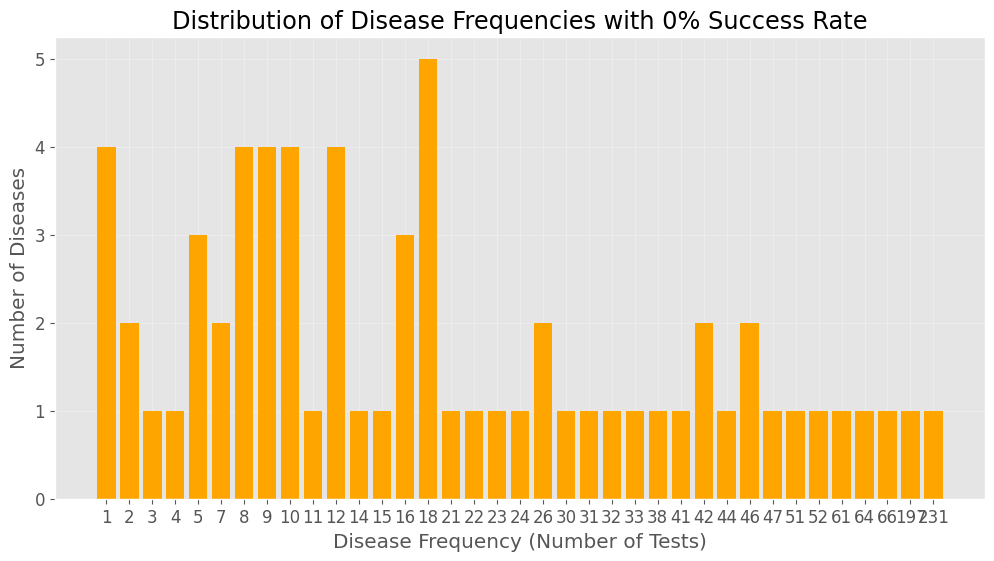

In [36]:
zero_diseases = df_diseases[df_diseases['success_rate'] == 0.0]
zero_count_distribution = Counter(zero_diseases['total_count'])
zero_counts = sorted(zero_count_distribution.items())

plt.figure(figsize=(12, 6))
plt.bar([str(count) for count, _ in zero_counts], [freq for _, freq in zero_counts], color='orange')
plt.title('Distribution of Disease Frequencies with 0% Success Rate')
plt.xlabel('Disease Frequency (Number of Tests)')
plt.ylabel('Number of Diseases')
plt.grid(True, alpha=0.3)
plt.show()

### 5. Privacy-Utility Trade-off Analysis

In [ ]:
epsilon_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0] # TODO: change this according to your test results. 
results = {}
   
for eps in epsilon_values:
    # TODO: change this!! if your results nname are different.
    file_path = f'results/evaluation_eps_{eps}.json'
    try:
        with open(file_path, 'r') as f:
            results[eps] = json.load(f)
    except FileNotFoundError:
        print(f"No data file found for epsilon={eps}")
   
privacy_utility = []
for eps, data in results.items():
    parsed = parse_evaluation(data)
    total = parsed.get("total_tests", 0)
    success = parsed.get(("symptoms", "*", eps, "success"), 0)
    success_rate = success / total if total > 0 else 0
       
    privacy_utility.append({
        "epsilon": eps,
        "privacy_level": 1/eps,  
        "success_rate": success_rate,
        "total_tests": total,
        "successful_tests": success
    })
   
df_privacy_utility = pd.DataFrame(privacy_utility)
   
# plot
plt.figure(figsize=(10, 6))
plt.plot(df_privacy_utility['epsilon'], df_privacy_utility['success_rate'], 
            'o-', linewidth=2, markersize=10)
plt.title('Privacy-Utility Tradeoff')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Success Rate (Utility)')
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()